In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

**Reflect Tables into SQLAlchemy ORM**

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
Base = automap_base()
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base.prepare(autoload_with=engine)
# reflect the tables



In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement_table = Base.classes.measurement
station_table = Base.classes.station

In [8]:
#create inspector and link to engine
inspector = inspect(engine)

In [9]:
#use the inspector to print the column names within measurement table
columns_m = inspector.get_columns('measurement')
for column in columns_m:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
#use the inspector to print the column names within station table
columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

**Exploratory Precipitation Analysis**

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement_table.date).order_by(measurement_table.date.desc()).first()
recent_date

('2017-08-23',)

(array([-500.,    0.,  500., 1000., 1500., 2000., 2500.]),
 [Text(-500.0, 0, '2017-05-27'),
  Text(0.0, 0, '2016-08-23'),
  Text(500.0, 0, '2016-11-09'),
  Text(1000.0, 0, '2017-01-28'),
  Text(1500.0, 0, '2017-04-18'),
  Text(2000.0, 0, '2017-07-10'),
  Text(2500.0, 0, '')])

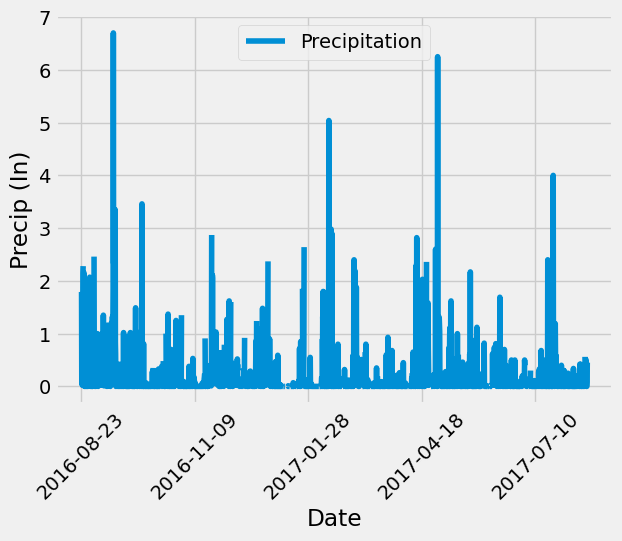

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
latest_date = dt.datetime.strptime(str(recent_date), "('%Y-%m-%d',)").date()
query_date = latest_date - dt.timedelta(days = 365)

# Perform a query to retrieve the data and precipitation scores
precip = session.query(measurement_table.date, measurement_table.prcp).filter(measurement_table.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip, columns = ['Date', 'Precipitation'])

# Sort the dataframe by date
precip_df.sort_values(by = 'Date', inplace = True)

# Use Pandas Plotting with Matplotlib to plot the data
precip_df.plot(x ='Date', y = 'Precipitation', ylabel = "Precip (In)")
plt.xticks(rotation = 45)

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


**Exploratory Station Analysis**

In [15]:
# Design a query to calculate the total number of stations in the dataset
total = session.query(station_table.station).distinct().count()
total

9

In [16]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
active = session.query(measurement_table.station, func.count(measurement_table.station)).group_by(measurement_table.station).\
        order_by(func.count(measurement_table.station).desc()).all()
# List the stations and their counts in descending order.
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#retrieve most active station ID
most_active = active[0][0]
most_active

#calculate the lowest, highest, and average temperature.
info = session.query(func.min(measurement_table.tobs), func.max(measurement_table.tobs), func.avg(measurement_table.tobs)).\
       filter(measurement_table.station == most_active).all()
info

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temp')

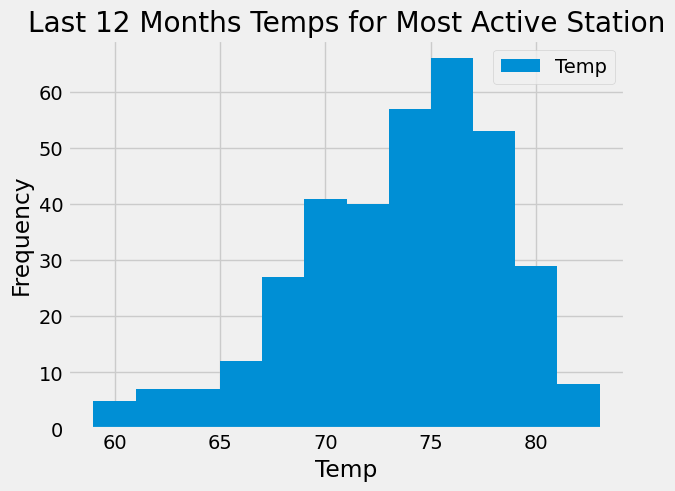

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

#query temps over year for most active station
temps = session.query(measurement_table.date, measurement_table.tobs).filter(measurement_table.date >= query_date).\
        filter(measurement_table.station == most_active).all()

#make dataframe
temps_df = pd.DataFrame(temps, columns = ["Date", "Temp"])

#plot the data
temp_hist = temps_df.plot.hist(column = "Temp", bins = 12, title = "Last 12 Months Temps for Most Active Station")
temp_hist.set_xlabel('Temp')


**Close Session**

In [19]:
# Close Session
session.close()